In [ ]:
!pip install -q --no-deps tensorflow-addons~=0.7
!pip install -q "tqdm>=4.36.1"
!pip install --upgrade "cloud-tpu-profiler>=1.15.0rc1"
import tensorflow_addons as tfa
import pathlib
import os
import re, time, datetime
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalMaxPooling2D,Dropout,Flatten,BatchNormalization,Activation
from tensorflow.keras.applications import NASNetLarge,VGG19
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.99.206.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.99.206.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
project_id = 'starlit-summit-281117'

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


In [ ]:
def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [ ]:
def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def image_example(image_string):
  label = image_labels[image_string]
  image_string2 = open(image_string, 'rb').read()
  image_shape = tf.image.decode_jpeg(image_string2).shape
  feature = {
    'image_raw': _bytes_feature(image_string2),
      'score': _float_feature(image_labels[image_string])}

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
def load_dataset(dataset):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    return dataset

In [ ]:
def _extract_fn(tfrecord):
    # Extract features using the keys set during creation
    features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'score': tf.io.FixedLenFeature([], tf.float32)}
    # Extract the data record
    sample = tf.io.parse_single_example(tfrecord, features)
    image = tf.image.decode_jpeg(sample['image'],3)  
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.resize_with_pad(image, 331,331 , method='lanczos3') 
    image = tf.cast(image, tf.float32)/255.
    score = sample['score']
    return [image, score]  

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
%load_ext tensorboard

In [ ]:
EPOCHS = 150
CYCLE = 150
BATCH_SIZE = 64
IMAGE_SIZE = [331, 331]
DATASET_SIZE = (2735+5081)
start_lr = 0.00001
min_lr = 0.00001
max_lr = (0.00005 * 8)
rampup_epochs = 4
sustain_epochs = 1
exp_decay = 0.85

gcs_pattern = 'gs://beholder/behold.tfrecords'

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

TRAIN_STEPS =  (train_size // BATCH_SIZE)
VAL_STEPS = (val_size // BATCH_SIZE)

1e-05 1.0000000026754073e-05


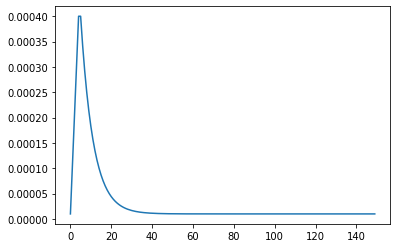

In [ ]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        elif epoch < (rampup_epochs + sustain_epochs + CYCLE):
            lr = (max_lr - min_lr) * exp_decay**(epoch -rampup_epochs -sustain_epochs) + min_lr
        
        elif epoch < (2*rampup_epochs + sustain_epochs + CYCLE):
            lr = (max_lr - min_lr)/rampup_epochs * (epoch - (rampup_epochs + sustain_epochs + CYCLE)) + min_lr

        elif epoch < 2*(rampup_epochs + sustain_epochs) + CYCLE:
            lr = max_lr

        elif epoch < 2*(rampup_epochs + sustain_epochs + CYCLE):
            lr = (max_lr - min_lr) * exp_decay**(epoch -(2*(rampup_epochs + sustain_epochs) + CYCLE)) + min_lr

        elif epoch < 2*(rampup_epochs + sustain_epochs + CYCLE)+ rampup_epochs :
            lr = (max_lr - min_lr)/rampup_epochs * (epoch - (2*(rampup_epochs + sustain_epochs + CYCLE))) + min_lr

        elif epoch < (2*(rampup_epochs + sustain_epochs + CYCLE)+ rampup_epochs + sustain_epochs):
            lr = max_lr

        elif epoch < 3*(rampup_epochs + sustain_epochs + CYCLE):
            lr = (max_lr - min_lr) * exp_decay**(epoch -(3*(rampup_epochs + sustain_epochs) + 2*CYCLE)) + min_lr

        elif epoch < 3*(rampup_epochs + sustain_epochs + CYCLE)+ rampup_epochs :
            lr = (max_lr - min_lr)/rampup_epochs * (epoch - (3*(rampup_epochs + sustain_epochs + CYCLE))) + min_lr

        elif epoch < 3*(rampup_epochs + sustain_epochs + CYCLE)+ rampup_epochs + sustain_epochs:
            lr = max_lr

        elif epoch < 4*(rampup_epochs + sustain_epochs + CYCLE):
            lr = (max_lr - min_lr) * exp_decay**(epoch -(4*(rampup_epochs + sustain_epochs) + 3*CYCLE)) + min_lr
        else:
            lr= min_lr

        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch))
checkpoint = ModelCheckpoint('drive/My Drive/Colab/1Cycle/model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', monitor='val_loss',save_best_only=False, save_weights_only=True, mode='min')

In [ ]:
raw_image_dataset = tf.data.TFRecordDataset(gcs_pattern)
parsed_image_dataset = raw_image_dataset.map(_extract_fn, num_parallel_calls=AUTO).cache()

train_dataset = parsed_image_dataset.take(train_size).shuffle(train_size)

test_dataset = parsed_image_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size).shuffle(val_size)
test_dataset = test_dataset.take(test_size)

train_dataset = train_dataset.repeat(EPOCHS)
val_dataset = val_dataset.repeat(EPOCHS)

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(AUTO)
val_dataset = val_dataset.prefetch(AUTO)
test_dataset = test_dataset.prefetch(AUTO)

In [ ]:
with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  pretrained_model = NASNetLarge(
      weights='imagenet', 
      include_top=False, 
      input_shape=(331, 331, 3))
  model = tf.keras.Sequential([
            pretrained_model,
            GlobalMaxPooling2D(),
            Dense(1000),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5),
            Dense(250),y§
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.5),
            Dense(1, activation='linear')])
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mean_absolute_percentage_error'])

343613440/343610240 [==============================] - 3s 0us/step


In [ ]:
log_dir1 = ("gs://beholder/tensorboard/{}".format(time.strftime('%Y-%m-%d-%H-%M-%S')))

print('Using model dir: {}'.format(log_dir1))

tensorboard = TensorBoard(log_dir=log_dir1, histogram_freq=5, write_graph=False, update_freq=5)

Using model dir: gs://beholder/tensorboard/2020-07-08-09-16-43


In [ ]:
start_time = time.time()
history = model.fit(train_dataset, validation_data=val_dataset,
                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS,
                    validation_steps=VAL_STEPS,
                    callbacks=[lr_callback,checkpoint,tensorboard], verbose=1)

final_accuracy = history.history["val_loss"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/150
 2/85 [..............................] - ETA: 5:38 - loss: 30.8612 - mean_absolute_error: 5.1896 - mean_absolute_percentage_error: 101.1754WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (4.368128). Check your callbacks.


 3/85 [>.............................] - ETA: 4:07 - loss: 31.4586 - mean_absolute_error: 5.2846 - mean_absolute_percentage_error: 101.2957WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.098458). Check your callbacks.


 4/85 [>.............................] - ETA: 3:13 - loss: 31.9484 - mean_absolute_error: 5.3493 - mean_absolute_percentage_error: 101.7146WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.558680). Check your callbacks.


85/85 [==============================] - 241s 3s/step - loss: 29.6586 - mean_absolute_error: 5.1675 - mean_absolute_percentage_error: 98.7378 - val_loss: 33.1587 - val_mean_absolute_error: 5.6082 - val_mean_absolute_percentage_error: 106.8187 - lr: 1.0000e-05
Epoch 2/150
 1/85 [..............................] - ETA: 0s - loss: 31.0513 - mean_absolute_error: 5.2455 - mean_absolute_percentage_error: 97.4709WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.912484). Check your callbacks.


85/85 [==============================] - 68s 804ms/step - loss: 23.9891 - mean_absolute_error: 4.6259 - mean_absolute_percentage_error: 89.2985 - val_loss: 22.0666 - val_mean_absolute_error: 4.5500 - val_mean_absolute_percentage_error: 86.3293 - lr: 1.0750e-04
Epoch 3/150
 1/85 [..............................] - ETA: 0s - loss: 19.7089 - mean_absolute_error: 4.2228 - mean_absolute_percentage_error: 81.2493WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.558177). Check your callbacks.


85/85 [==============================] - 67s 792ms/step - loss: 13.8521 - mean_absolute_error: 3.3733 - mean_absolute_percentage_error: 64.5774 - val_loss: 6.2184 - val_mean_absolute_error: 2.3101 - val_mean_absolute_percentage_error: 43.1963 - lr: 2.0500e-04
Epoch 4/150
 1/85 [..............................] - ETA: 0s - loss: 9.2733 - mean_absolute_error: 2.7769 - mean_absolute_percentage_error: 54.1589WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.723956). Check your callbacks.


85/85 [==============================] - 67s 792ms/step - loss: 5.6342 - mean_absolute_error: 1.9883 - mean_absolute_percentage_error: 37.9628 - val_loss: 1.4928 - val_mean_absolute_error: 0.9894 - val_mean_absolute_percentage_error: 19.7384 - lr: 3.0250e-04
Epoch 5/150
 1/85 [..............................] - ETA: 0s - loss: 4.4808 - mean_absolute_error: 1.7395 - mean_absolute_percentage_error: 32.8955WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.555111). Check your callbacks.


85/85 [==============================] - 67s 791ms/step - loss: 2.7667 - mean_absolute_error: 1.3292 - mean_absolute_percentage_error: 25.8405 - val_loss: 3.1267 - val_mean_absolute_error: 1.4620 - val_mean_absolute_percentage_error: 27.9945 - lr: 4.0000e-04
Epoch 6/150
 1/85 [..............................] - ETA: 0s - loss: 2.1672 - mean_absolute_error: 1.2094 - mean_absolute_percentage_error: 23.5799WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.685227). Check your callbacks.


85/85 [==============================] - 197s 2s/step - loss: 2.3518 - mean_absolute_error: 1.2178 - mean_absolute_percentage_error: 24.2162 - val_loss: 4.4776 - val_mean_absolute_error: 1.7149 - val_mean_absolute_percentage_error: 30.7775 - lr: 4.0000e-04
Epoch 7/150
 1/85 [..............................] - ETA: 0s - loss: 2.1235 - mean_absolute_error: 1.1127 - mean_absolute_percentage_error: 22.6636WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.806036). Check your callbacks.


85/85 [==============================] - 69s 807ms/step - loss: 2.2126 - mean_absolute_error: 1.1688 - mean_absolute_percentage_error: 23.1635 - val_loss: 9.1379 - val_mean_absolute_error: 2.4471 - val_mean_absolute_percentage_error: 45.1552 - lr: 3.4150e-04
Epoch 8/150
 1/85 [..............................] - ETA: 0s - loss: 2.3680 - mean_absolute_error: 1.2123 - mean_absolute_percentage_error: 24.3019WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.684693). Check your callbacks.


85/85 [==============================] - 68s 801ms/step - loss: 2.0437 - mean_absolute_error: 1.1374 - mean_absolute_percentage_error: 22.7614 - val_loss: 11.4796 - val_mean_absolute_error: 2.5048 - val_mean_absolute_percentage_error: 43.6573 - lr: 2.9178e-04
Epoch 9/150
 1/85 [..............................] - ETA: 0s - loss: 1.4966 - mean_absolute_error: 0.9706 - mean_absolute_percentage_error: 19.6474WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.609473). Check your callbacks.


85/85 [==============================] - 70s 824ms/step - loss: 1.9040 - mean_absolute_error: 1.0933 - mean_absolute_percentage_error: 21.8822 - val_loss: 3.0563 - val_mean_absolute_error: 1.4008 - val_mean_absolute_percentage_error: 25.4951 - lr: 2.4951e-04
Epoch 10/150
 1/85 [..............................] - ETA: 0s - loss: 1.5190 - mean_absolute_error: 0.9959 - mean_absolute_percentage_error: 20.1671WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.033667). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 2.0941 - mean_absolute_error: 1.1664 - mean_absolute_percentage_error: 22.4380WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.524449). Check your callbacks.


85/85 [==============================] - 68s 802ms/step - loss: 1.8240 - mean_absolute_error: 1.0632 - mean_absolute_percentage_error: 21.1918 - val_loss: 1.7138 - val_mean_absolute_error: 1.1028 - val_mean_absolute_percentage_error: 20.5442 - lr: 2.1358e-04
Epoch 11/150
 1/85 [..............................] - ETA: 0s - loss: 1.7459 - mean_absolute_error: 1.0317 - mean_absolute_percentage_error: 19.1766WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.835548). Check your callbacks.


85/85 [==============================] - 215s 3s/step - loss: 1.7764 - mean_absolute_error: 1.0548 - mean_absolute_percentage_error: 20.9760 - val_loss: 1.8330 - val_mean_absolute_error: 1.1353 - val_mean_absolute_percentage_error: 21.2954 - lr: 1.8305e-04
Epoch 12/150
 1/85 [..............................] - ETA: 0s - loss: 1.6946 - mean_absolute_error: 1.0483 - mean_absolute_percentage_error: 19.4859WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.628723). Check your callbacks.


85/85 [==============================] - 70s 824ms/step - loss: 1.7173 - mean_absolute_error: 1.0293 - mean_absolute_percentage_error: 20.5922 - val_loss: 1.5765 - val_mean_absolute_error: 1.0548 - val_mean_absolute_percentage_error: 19.8472 - lr: 1.5709e-04
Epoch 13/150
 1/85 [..............................] - ETA: 0s - loss: 1.2587 - mean_absolute_error: 0.9097 - mean_absolute_percentage_error: 19.0182WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.559473). Check your callbacks.


85/85 [==============================] - 69s 809ms/step - loss: 1.6550 - mean_absolute_error: 1.0154 - mean_absolute_percentage_error: 20.2457 - val_loss: 1.4012 - val_mean_absolute_error: 0.9731 - val_mean_absolute_percentage_error: 17.5676 - lr: 1.3503e-04
Epoch 14/150
 1/85 [..............................] - ETA: 0s - loss: 1.9701 - mean_absolute_error: 1.1760 - mean_absolute_percentage_error: 23.1698WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.602349). Check your callbacks.


85/85 [==============================] - 68s 804ms/step - loss: 1.6211 - mean_absolute_error: 1.0085 - mean_absolute_percentage_error: 20.0536 - val_loss: 0.8938 - val_mean_absolute_error: 0.7547 - val_mean_absolute_percentage_error: 14.3481 - lr: 1.1627e-04
Epoch 15/150
 1/85 [..............................] - ETA: 0s - loss: 1.8551 - mean_absolute_error: 1.0409 - mean_absolute_percentage_error: 19.6361WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.969807). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.6116 - mean_absolute_error: 1.0120 - mean_absolute_percentage_error: 19.0953WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.493601). Check your callbacks.


85/85 [==============================] - 71s 836ms/step - loss: 1.5415 - mean_absolute_error: 0.9847 - mean_absolute_percentage_error: 19.5220 - val_loss: 0.7912 - val_mean_absolute_error: 0.7001 - val_mean_absolute_percentage_error: 13.0411 - lr: 1.0033e-04
Epoch 16/150
 1/85 [..............................] - ETA: 0s - loss: 1.2428 - mean_absolute_error: 0.8705 - mean_absolute_percentage_error: 17.6925WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.707405). Check your callbacks.


85/85 [==============================] - 212s 2s/step - loss: 1.4916 - mean_absolute_error: 0.9655 - mean_absolute_percentage_error: 19.3259 - val_loss: 1.0299 - val_mean_absolute_error: 0.8123 - val_mean_absolute_percentage_error: 14.5556 - lr: 8.6781e-05
Epoch 17/150
 1/85 [..............................] - ETA: 0s - loss: 1.5473 - mean_absolute_error: 0.9490 - mean_absolute_percentage_error: 18.9257WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.840177). Check your callbacks.


85/85 [==============================] - 71s 834ms/step - loss: 1.4542 - mean_absolute_error: 0.9518 - mean_absolute_percentage_error: 18.9698 - val_loss: 1.4884 - val_mean_absolute_error: 1.0411 - val_mean_absolute_percentage_error: 19.1887 - lr: 7.5264e-05
Epoch 18/150
 1/85 [..............................] - ETA: 0s - loss: 2.0372 - mean_absolute_error: 1.0954 - mean_absolute_percentage_error: 24.1702WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.953875). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.8292 - mean_absolute_error: 1.0534 - mean_absolute_percentage_error: 21.9454WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.485433). Check your callbacks.


85/85 [==============================] - 70s 823ms/step - loss: 1.4411 - mean_absolute_error: 0.9558 - mean_absolute_percentage_error: 19.0959 - val_loss: 1.5650 - val_mean_absolute_error: 1.0688 - val_mean_absolute_percentage_error: 19.3332 - lr: 6.5474e-05
Epoch 19/150
 1/85 [..............................] - ETA: 0s - loss: 1.8781 - mean_absolute_error: 1.0575 - mean_absolute_percentage_error: 20.6331WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.592054). Check your callbacks.


85/85 [==============================] - 70s 824ms/step - loss: 1.4170 - mean_absolute_error: 0.9411 - mean_absolute_percentage_error: 18.7294 - val_loss: 1.7728 - val_mean_absolute_error: 1.1546 - val_mean_absolute_percentage_error: 20.8501 - lr: 5.7153e-05
Epoch 20/150
 1/85 [..............................] - ETA: 0s - loss: 0.9392 - mean_absolute_error: 0.7582 - mean_absolute_percentage_error: 15.2202WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.665889). Check your callbacks.


85/85 [==============================] - 70s 828ms/step - loss: 1.3263 - mean_absolute_error: 0.9167 - mean_absolute_percentage_error: 18.2997 - val_loss: 1.3364 - val_mean_absolute_error: 0.9524 - val_mean_absolute_percentage_error: 16.9569 - lr: 5.0080e-05
Epoch 21/150
 1/85 [..............................] - ETA: 0s - loss: 1.2685 - mean_absolute_error: 0.8415 - mean_absolute_percentage_error: 16.3838WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.010475). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2567 - mean_absolute_error: 0.8763 - mean_absolute_percentage_error: 17.3774WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.514191). Check your callbacks.


85/85 [==============================] - 222s 3s/step - loss: 1.3492 - mean_absolute_error: 0.9119 - mean_absolute_percentage_error: 18.1720 - val_loss: 1.4681 - val_mean_absolute_error: 1.0096 - val_mean_absolute_percentage_error: 17.8625 - lr: 4.4068e-05
Epoch 22/150
 1/85 [..............................] - ETA: 0s - loss: 1.3863 - mean_absolute_error: 0.9369 - mean_absolute_percentage_error: 19.2144WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.831548). Check your callbacks.


85/85 [==============================] - 71s 835ms/step - loss: 1.3367 - mean_absolute_error: 0.9144 - mean_absolute_percentage_error: 18.1880 - val_loss: 1.3167 - val_mean_absolute_error: 0.9256 - val_mean_absolute_percentage_error: 16.2833 - lr: 3.8958e-05
Epoch 23/150
 1/85 [..............................] - ETA: 0s - loss: 1.0952 - mean_absolute_error: 0.8413 - mean_absolute_percentage_error: 17.4963WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.756339). Check your callbacks.


85/85 [==============================] - 70s 824ms/step - loss: 1.2500 - mean_absolute_error: 0.8874 - mean_absolute_percentage_error: 17.7613 - val_loss: 1.3957 - val_mean_absolute_error: 0.9941 - val_mean_absolute_percentage_error: 17.8805 - lr: 3.4614e-05
Epoch 24/150
 1/85 [..............................] - ETA: 0s - loss: 1.1445 - mean_absolute_error: 0.8248 - mean_absolute_percentage_error: 16.6245WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.069798). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.4146 - mean_absolute_error: 0.9409 - mean_absolute_percentage_error: 19.3735WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.542554). Check your callbacks.


85/85 [==============================] - 71s 834ms/step - loss: 1.3263 - mean_absolute_error: 0.9146 - mean_absolute_percentage_error: 18.1778 - val_loss: 1.5680 - val_mean_absolute_error: 1.0546 - val_mean_absolute_percentage_error: 18.9504 - lr: 3.0922e-05
Epoch 25/150
 1/85 [..............................] - ETA: 0s - loss: 1.1035 - mean_absolute_error: 0.8741 - mean_absolute_percentage_error: 17.1514WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.111932). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.3377 - mean_absolute_error: 0.9272 - mean_absolute_percentage_error: 18.6119WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.564836). Check your callbacks.


85/85 [==============================] - 72s 850ms/step - loss: 1.2657 - mean_absolute_error: 0.8912 - mean_absolute_percentage_error: 17.8134 - val_loss: 1.6771 - val_mean_absolute_error: 1.0921 - val_mean_absolute_percentage_error: 19.4834 - lr: 2.7784e-05
Epoch 26/150
 1/85 [..............................] - ETA: 0s - loss: 1.6109 - mean_absolute_error: 0.9882 - mean_absolute_percentage_error: 19.1346WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.847358). Check your callbacks.


85/85 [==============================] - 238s 3s/step - loss: 1.2440 - mean_absolute_error: 0.8831 - mean_absolute_percentage_error: 17.5706 - val_loss: 1.3024 - val_mean_absolute_error: 0.9119 - val_mean_absolute_percentage_error: 16.0885 - lr: 2.5116e-05
Epoch 27/150
 1/85 [..............................] - ETA: 0s - loss: 0.9102 - mean_absolute_error: 0.7679 - mean_absolute_percentage_error: 15.1869WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.153453). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0472 - mean_absolute_error: 0.7984 - mean_absolute_percentage_error: 16.0098WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.584811). Check your callbacks.


85/85 [==============================] - 71s 839ms/step - loss: 1.2296 - mean_absolute_error: 0.8725 - mean_absolute_percentage_error: 17.4445 - val_loss: 1.4198 - val_mean_absolute_error: 0.9918 - val_mean_absolute_percentage_error: 17.6837 - lr: 2.2849e-05
Epoch 28/150
 1/85 [..............................] - ETA: 0s - loss: 1.1996 - mean_absolute_error: 0.8833 - mean_absolute_percentage_error: 18.0988WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.733576). Check your callbacks.


85/85 [==============================] - 72s 846ms/step - loss: 1.2122 - mean_absolute_error: 0.8717 - mean_absolute_percentage_error: 17.3205 - val_loss: 1.4130 - val_mean_absolute_error: 1.0059 - val_mean_absolute_percentage_error: 18.1255 - lr: 2.0921e-05
Epoch 29/150
 1/85 [..............................] - ETA: 0s - loss: 1.2841 - mean_absolute_error: 0.9299 - mean_absolute_percentage_error: 17.1648WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.006030). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2063 - mean_absolute_error: 0.9195 - mean_absolute_percentage_error: 17.8240WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.511719). Check your callbacks.


85/85 [==============================] - 73s 858ms/step - loss: 1.2002 - mean_absolute_error: 0.8691 - mean_absolute_percentage_error: 17.3139 - val_loss: 1.5721 - val_mean_absolute_error: 1.0167 - val_mean_absolute_percentage_error: 17.9753 - lr: 1.9283e-05
Epoch 30/150
 1/85 [..............................] - ETA: 0s - loss: 1.5517 - mean_absolute_error: 1.0257 - mean_absolute_percentage_error: 20.1161WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.282562). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2791 - mean_absolute_error: 0.8930 - mean_absolute_percentage_error: 17.1374WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.648824). Check your callbacks.


85/85 [==============================] - 73s 864ms/step - loss: 1.1930 - mean_absolute_error: 0.8649 - mean_absolute_percentage_error: 17.2256 - val_loss: 1.5720 - val_mean_absolute_error: 1.0225 - val_mean_absolute_percentage_error: 18.0686 - lr: 1.7891e-05
Epoch 31/150
 1/85 [..............................] - ETA: 0s - loss: 0.9212 - mean_absolute_error: 0.7875 - mean_absolute_percentage_error: 14.9923WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.213004). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9680 - mean_absolute_error: 0.7953 - mean_absolute_percentage_error: 15.1928WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.615363). Check your callbacks.


85/85 [==============================] - 237s 3s/step - loss: 1.2171 - mean_absolute_error: 0.8704 - mean_absolute_percentage_error: 17.2149 - val_loss: 1.5007 - val_mean_absolute_error: 0.9749 - val_mean_absolute_percentage_error: 17.0862 - lr: 1.6707e-05
Epoch 32/150
 1/85 [..............................] - ETA: 0s - loss: 0.9815 - mean_absolute_error: 0.8286 - mean_absolute_percentage_error: 16.8995WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.162153). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.3452 - mean_absolute_error: 0.8973 - mean_absolute_percentage_error: 17.4801WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.588327). Check your callbacks.


85/85 [==============================] - 73s 855ms/step - loss: 1.2042 - mean_absolute_error: 0.8644 - mean_absolute_percentage_error: 17.1456 - val_loss: 1.3877 - val_mean_absolute_error: 0.9465 - val_mean_absolute_percentage_error: 16.6401 - lr: 1.5701e-05
Epoch 33/150
 1/85 [..............................] - ETA: 0s - loss: 1.1479 - mean_absolute_error: 0.8605 - mean_absolute_percentage_error: 16.1560WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.864188). Check your callbacks.


85/85 [==============================] - 72s 852ms/step - loss: 1.2085 - mean_absolute_error: 0.8674 - mean_absolute_percentage_error: 17.2193 - val_loss: 1.7709 - val_mean_absolute_error: 1.0441 - val_mean_absolute_percentage_error: 18.1367 - lr: 1.4846e-05
Epoch 34/150
 1/85 [..............................] - ETA: 0s - loss: 0.7908 - mean_absolute_error: 0.7181 - mean_absolute_percentage_error: 14.5926WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.297724). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8458 - mean_absolute_error: 0.7338 - mean_absolute_percentage_error: 14.8531WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.657364). Check your callbacks.


85/85 [==============================] - 74s 875ms/step - loss: 1.1561 - mean_absolute_error: 0.8543 - mean_absolute_percentage_error: 17.0312 - val_loss: 1.3489 - val_mean_absolute_error: 0.9311 - val_mean_absolute_percentage_error: 16.4306 - lr: 1.4119e-05
Epoch 35/150
 1/85 [..............................] - ETA: 0s - loss: 1.0715 - mean_absolute_error: 0.8441 - mean_absolute_percentage_error: 17.6971WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.755330). Check your callbacks.


85/85 [==============================] - 71s 839ms/step - loss: 1.1808 - mean_absolute_error: 0.8552 - mean_absolute_percentage_error: 17.0321 - val_loss: 1.5088 - val_mean_absolute_error: 0.9641 - val_mean_absolute_percentage_error: 16.8037 - lr: 1.3501e-05
Epoch 36/150
 1/85 [..............................] - ETA: 0s - loss: 1.4015 - mean_absolute_error: 0.9304 - mean_absolute_percentage_error: 19.2799WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.000343). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.3959 - mean_absolute_error: 0.9435 - mean_absolute_percentage_error: 19.8411WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.509031). Check your callbacks.


85/85 [==============================] - 230s 3s/step - loss: 1.1893 - mean_absolute_error: 0.8578 - mean_absolute_percentage_error: 17.0438 - val_loss: 1.5606 - val_mean_absolute_error: 0.9902 - val_mean_absolute_percentage_error: 17.3277 - lr: 1.2976e-05
Epoch 37/150
 1/85 [..............................] - ETA: 0s - loss: 1.0422 - mean_absolute_error: 0.7883 - mean_absolute_percentage_error: 14.6630WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.701804). Check your callbacks.


85/85 [==============================] - 72s 851ms/step - loss: 1.1178 - mean_absolute_error: 0.8383 - mean_absolute_percentage_error: 16.6962 - val_loss: 1.5029 - val_mean_absolute_error: 0.9831 - val_mean_absolute_percentage_error: 17.3513 - lr: 1.2530e-05
Epoch 38/150
 1/85 [..............................] - ETA: 0s - loss: 1.2379 - mean_absolute_error: 0.8589 - mean_absolute_percentage_error: 17.3048WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.267958). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0689 - mean_absolute_error: 0.8162 - mean_absolute_percentage_error: 16.3918WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.641747). Check your callbacks.


85/85 [==============================] - 73s 858ms/step - loss: 1.1055 - mean_absolute_error: 0.8319 - mean_absolute_percentage_error: 16.5434 - val_loss: 1.5688 - val_mean_absolute_error: 0.9985 - val_mean_absolute_percentage_error: 17.5858 - lr: 1.2150e-05
Epoch 39/150
 1/85 [..............................] - ETA: 0s - loss: 1.2029 - mean_absolute_error: 0.8621 - mean_absolute_percentage_error: 17.8859WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.190088). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2248 - mean_absolute_error: 0.8797 - mean_absolute_percentage_error: 17.9190WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.603059). Check your callbacks.


85/85 [==============================] - 72s 850ms/step - loss: 1.1164 - mean_absolute_error: 0.8290 - mean_absolute_percentage_error: 16.4938 - val_loss: 1.6580 - val_mean_absolute_error: 1.0300 - val_mean_absolute_percentage_error: 18.0735 - lr: 1.1828e-05
Epoch 40/150
 1/85 [..............................] - ETA: 0s - loss: 1.3882 - mean_absolute_error: 0.9781 - mean_absolute_percentage_error: 19.2315WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.009677). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2010 - mean_absolute_error: 0.8810 - mean_absolute_percentage_error: 17.2844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.513533). Check your callbacks.


85/85 [==============================] - 75s 878ms/step - loss: 1.1609 - mean_absolute_error: 0.8555 - mean_absolute_percentage_error: 16.9688 - val_loss: 1.8438 - val_mean_absolute_error: 1.0918 - val_mean_absolute_percentage_error: 19.1731 - lr: 1.1553e-05
Epoch 41/150
 1/85 [..............................] - ETA: 0s - loss: 1.5621 - mean_absolute_error: 1.0147 - mean_absolute_percentage_error: 19.7724WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.211174). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2441 - mean_absolute_error: 0.8961 - mean_absolute_percentage_error: 18.0387WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.616101). Check your callbacks.


85/85 [==============================] - 241s 3s/step - loss: 1.1055 - mean_absolute_error: 0.8302 - mean_absolute_percentage_error: 16.6209 - val_loss: 1.6965 - val_mean_absolute_error: 1.0492 - val_mean_absolute_percentage_error: 18.4627 - lr: 1.1320e-05
Epoch 42/150
 1/85 [..............................] - ETA: 0s - loss: 1.3468 - mean_absolute_error: 0.8418 - mean_absolute_percentage_error: 16.0048WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.313872). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1835 - mean_absolute_error: 0.8008 - mean_absolute_percentage_error: 15.0910WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.664892). Check your callbacks.


85/85 [==============================] - 73s 864ms/step - loss: 1.0903 - mean_absolute_error: 0.8192 - mean_absolute_percentage_error: 16.3423 - val_loss: 1.4825 - val_mean_absolute_error: 0.9596 - val_mean_absolute_percentage_error: 16.8200 - lr: 1.1122e-05
Epoch 43/150
 1/85 [..............................] - ETA: 0s - loss: 1.0683 - mean_absolute_error: 0.8648 - mean_absolute_percentage_error: 16.4226WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.275000). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9440 - mean_absolute_error: 0.7905 - mean_absolute_percentage_error: 15.8069WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.645800). Check your callbacks.


85/85 [==============================] - 73s 865ms/step - loss: 1.1068 - mean_absolute_error: 0.8309 - mean_absolute_percentage_error: 16.5582 - val_loss: 1.4402 - val_mean_absolute_error: 0.9517 - val_mean_absolute_percentage_error: 16.7689 - lr: 1.0954e-05
Epoch 44/150
 1/85 [..............................] - ETA: 0s - loss: 1.2725 - mean_absolute_error: 0.9166 - mean_absolute_percentage_error: 17.5847WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.878560). Check your callbacks.


85/85 [==============================] - 72s 850ms/step - loss: 1.0717 - mean_absolute_error: 0.8204 - mean_absolute_percentage_error: 16.3336 - val_loss: 1.4215 - val_mean_absolute_error: 0.9675 - val_mean_absolute_percentage_error: 17.2265 - lr: 1.0811e-05
Epoch 45/150
 1/85 [..............................] - ETA: 0s - loss: 0.9965 - mean_absolute_error: 0.7867 - mean_absolute_percentage_error: 16.9743WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.272925). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1131 - mean_absolute_error: 0.8514 - mean_absolute_percentage_error: 17.1543WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.644027). Check your callbacks.


85/85 [==============================] - 74s 865ms/step - loss: 1.0720 - mean_absolute_error: 0.8232 - mean_absolute_percentage_error: 16.4395 - val_loss: 1.3077 - val_mean_absolute_error: 0.9129 - val_mean_absolute_percentage_error: 16.1362 - lr: 1.0689e-05
Epoch 46/150
 1/85 [..............................] - ETA: 0s - loss: 1.1660 - mean_absolute_error: 0.8054 - mean_absolute_percentage_error: 15.1637WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.312347). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1163 - mean_absolute_error: 0.7971 - mean_absolute_percentage_error: 15.1191WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.663736). Check your callbacks.


85/85 [==============================] - 243s 3s/step - loss: 1.0502 - mean_absolute_error: 0.8089 - mean_absolute_percentage_error: 16.0389 - val_loss: 1.4128 - val_mean_absolute_error: 0.9711 - val_mean_absolute_percentage_error: 17.3918 - lr: 1.0586e-05
Epoch 47/150
 1/85 [..............................] - ETA: 0s - loss: 1.0925 - mean_absolute_error: 0.8226 - mean_absolute_percentage_error: 16.9398WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.007540). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1278 - mean_absolute_error: 0.8216 - mean_absolute_percentage_error: 16.7005WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.512572). Check your callbacks.


85/85 [==============================] - 73s 863ms/step - loss: 1.0520 - mean_absolute_error: 0.8097 - mean_absolute_percentage_error: 16.1572 - val_loss: 1.4573 - val_mean_absolute_error: 0.9798 - val_mean_absolute_percentage_error: 17.4895 - lr: 1.0498e-05
Epoch 48/150
 1/85 [..............................] - ETA: 0s - loss: 1.0759 - mean_absolute_error: 0.8675 - mean_absolute_percentage_error: 17.4255WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.524742). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0785 - mean_absolute_error: 0.8549 - mean_absolute_percentage_error: 16.7700WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.770266). Check your callbacks.


85/85 [==============================] - 77s 911ms/step - loss: 1.0567 - mean_absolute_error: 0.8129 - mean_absolute_percentage_error: 16.2046 - val_loss: 1.3357 - val_mean_absolute_error: 0.9350 - val_mean_absolute_percentage_error: 16.7037 - lr: 1.0423e-05
Epoch 49/150
 1/85 [..............................] - ETA: 0s - loss: 0.6112 - mean_absolute_error: 0.6189 - mean_absolute_percentage_error: 12.7020WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.369745). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9712 - mean_absolute_error: 0.7743 - mean_absolute_percentage_error: 15.2901WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.692607). Check your callbacks.


85/85 [==============================] - 72s 850ms/step - loss: 1.0584 - mean_absolute_error: 0.8147 - mean_absolute_percentage_error: 16.2590 - val_loss: 1.2128 - val_mean_absolute_error: 0.8959 - val_mean_absolute_percentage_error: 16.0439 - lr: 1.0360e-05
Epoch 50/150
 1/85 [..............................] - ETA: 0s - loss: 1.3457 - mean_absolute_error: 0.8995 - mean_absolute_percentage_error: 16.3653WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.163954). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2185 - mean_absolute_error: 0.8682 - mean_absolute_percentage_error: 16.1605WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.589406). Check your callbacks.


85/85 [==============================] - 74s 871ms/step - loss: 1.0627 - mean_absolute_error: 0.8133 - mean_absolute_percentage_error: 16.0091 - val_loss: 1.2939 - val_mean_absolute_error: 0.9166 - val_mean_absolute_percentage_error: 16.2689 - lr: 1.0306e-05
Epoch 51/150
 1/85 [..............................] - ETA: 0s - loss: 0.8634 - mean_absolute_error: 0.7229 - mean_absolute_percentage_error: 14.1726WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.351905). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0328 - mean_absolute_error: 0.8015 - mean_absolute_percentage_error: 16.9186WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.684836). Check your callbacks.


85/85 [==============================] - 250s 3s/step - loss: 1.0131 - mean_absolute_error: 0.8027 - mean_absolute_percentage_error: 15.9733 - val_loss: 1.3948 - val_mean_absolute_error: 0.9502 - val_mean_absolute_percentage_error: 16.9126 - lr: 1.0260e-05
Epoch 52/150
 1/85 [..............................] - ETA: 0s - loss: 0.7637 - mean_absolute_error: 0.7118 - mean_absolute_percentage_error: 14.5188WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.264391). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8195 - mean_absolute_error: 0.7300 - mean_absolute_percentage_error: 15.0183WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.640576). Check your callbacks.


85/85 [==============================] - 75s 886ms/step - loss: 1.0109 - mean_absolute_error: 0.7991 - mean_absolute_percentage_error: 16.0149 - val_loss: 1.4124 - val_mean_absolute_error: 0.9555 - val_mean_absolute_percentage_error: 16.9931 - lr: 1.0221e-05
Epoch 53/150
 1/85 [..............................] - ETA: 0s - loss: 1.0037 - mean_absolute_error: 0.7668 - mean_absolute_percentage_error: 15.1378WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.325510). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0677 - mean_absolute_error: 0.8037 - mean_absolute_percentage_error: 16.3161WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.671027). Check your callbacks.


85/85 [==============================] - 80s 936ms/step - loss: 1.0435 - mean_absolute_error: 0.8076 - mean_absolute_percentage_error: 16.0456 - val_loss: 1.2286 - val_mean_absolute_error: 0.8715 - val_mean_absolute_percentage_error: 15.4579 - lr: 1.0188e-05
Epoch 54/150
 1/85 [..............................] - ETA: 0s - loss: 1.2157 - mean_absolute_error: 0.8001 - mean_absolute_percentage_error: 16.4707WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.959874). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.2774 - mean_absolute_error: 0.8544 - mean_absolute_percentage_error: 16.8587WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.488476). Check your callbacks.


85/85 [==============================] - 76s 899ms/step - loss: 0.9873 - mean_absolute_error: 0.7829 - mean_absolute_percentage_error: 15.5354 - val_loss: 1.3527 - val_mean_absolute_error: 0.9388 - val_mean_absolute_percentage_error: 16.7646 - lr: 1.0160e-05
Epoch 55/150
 1/85 [..............................] - ETA: 0s - loss: 1.0342 - mean_absolute_error: 0.8340 - mean_absolute_percentage_error: 16.9093WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.256100). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9277 - mean_absolute_error: 0.7639 - mean_absolute_percentage_error: 15.5034WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.635234). Check your callbacks.


85/85 [==============================] - 74s 872ms/step - loss: 1.0016 - mean_absolute_error: 0.7908 - mean_absolute_percentage_error: 15.8330 - val_loss: 1.2952 - val_mean_absolute_error: 0.8770 - val_mean_absolute_percentage_error: 15.3342 - lr: 1.0136e-05
Epoch 56/150
 1/85 [..............................] - ETA: 0s - loss: 1.1751 - mean_absolute_error: 0.8667 - mean_absolute_percentage_error: 16.9425WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.242905). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0775 - mean_absolute_error: 0.8216 - mean_absolute_percentage_error: 16.5478WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.628448). Check your callbacks.


85/85 [==============================] - 245s 3s/step - loss: 1.0087 - mean_absolute_error: 0.7912 - mean_absolute_percentage_error: 15.6344 - val_loss: 1.1664 - val_mean_absolute_error: 0.8523 - val_mean_absolute_percentage_error: 15.2607 - lr: 1.0115e-05
Epoch 57/150
 1/85 [..............................] - ETA: 0s - loss: 0.9317 - mean_absolute_error: 0.7924 - mean_absolute_percentage_error: 14.7040WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.243245). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1978 - mean_absolute_error: 0.8800 - mean_absolute_percentage_error: 17.4629WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.629811). Check your callbacks.


85/85 [==============================] - 74s 872ms/step - loss: 1.0001 - mean_absolute_error: 0.7891 - mean_absolute_percentage_error: 15.7237 - val_loss: 1.2305 - val_mean_absolute_error: 0.8624 - val_mean_absolute_percentage_error: 15.4125 - lr: 1.0098e-05
Epoch 58/150
 1/85 [..............................] - ETA: 0s - loss: 1.0210 - mean_absolute_error: 0.8236 - mean_absolute_percentage_error: 16.4255WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.934754). Check your callbacks.


85/85 [==============================] - 76s 900ms/step - loss: 1.0070 - mean_absolute_error: 0.7939 - mean_absolute_percentage_error: 15.7981 - val_loss: 1.1964 - val_mean_absolute_error: 0.8973 - val_mean_absolute_percentage_error: 16.1961 - lr: 1.0083e-05
Epoch 59/150
 1/85 [..............................] - ETA: 0s - loss: 1.2802 - mean_absolute_error: 0.9177 - mean_absolute_percentage_error: 17.7708WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.840704). Check your callbacks.


85/85 [==============================] - 75s 884ms/step - loss: 0.9669 - mean_absolute_error: 0.7820 - mean_absolute_percentage_error: 15.5155 - val_loss: 0.9701 - val_mean_absolute_error: 0.8033 - val_mean_absolute_percentage_error: 14.6638 - lr: 1.0071e-05
Epoch 60/150
 1/85 [..............................] - ETA: 0s - loss: 1.2312 - mean_absolute_error: 0.8978 - mean_absolute_percentage_error: 19.2288WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.267725). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1417 - mean_absolute_error: 0.8635 - mean_absolute_percentage_error: 18.1931WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.641932). Check your callbacks.


85/85 [==============================] - 76s 895ms/step - loss: 0.9604 - mean_absolute_error: 0.7759 - mean_absolute_percentage_error: 15.4369 - val_loss: 1.0323 - val_mean_absolute_error: 0.8304 - val_mean_absolute_percentage_error: 15.0808 - lr: 1.0060e-05
Epoch 61/150
 1/85 [..............................] - ETA: 0s - loss: 0.8710 - mean_absolute_error: 0.7384 - mean_absolute_percentage_error: 15.3997WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.282593). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.1292 - mean_absolute_error: 0.8633 - mean_absolute_percentage_error: 17.2992WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.651229). Check your callbacks.


85/85 [==============================] - 249s 3s/step - loss: 0.9834 - mean_absolute_error: 0.7821 - mean_absolute_percentage_error: 15.6819 - val_loss: 1.1412 - val_mean_absolute_error: 0.8700 - val_mean_absolute_percentage_error: 15.8079 - lr: 1.0051e-05
Epoch 62/150
 1/85 [..............................] - ETA: 0s - loss: 0.6951 - mean_absolute_error: 0.6429 - mean_absolute_percentage_error: 13.2938WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.005786). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8635 - mean_absolute_error: 0.7300 - mean_absolute_percentage_error: 14.5850WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.510656). Check your callbacks.


85/85 [==============================] - 77s 903ms/step - loss: 0.9588 - mean_absolute_error: 0.7742 - mean_absolute_percentage_error: 15.2818 - val_loss: 0.8400 - val_mean_absolute_error: 0.7399 - val_mean_absolute_percentage_error: 13.6060 - lr: 1.0044e-05
Epoch 63/150
 1/85 [..............................] - ETA: 0s - loss: 0.9390 - mean_absolute_error: 0.7907 - mean_absolute_percentage_error: 16.2038WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.251125). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8972 - mean_absolute_error: 0.7605 - mean_absolute_percentage_error: 16.3455WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.634727). Check your callbacks.


85/85 [==============================] - 75s 886ms/step - loss: 0.9465 - mean_absolute_error: 0.7675 - mean_absolute_percentage_error: 15.3552 - val_loss: 1.0859 - val_mean_absolute_error: 0.8685 - val_mean_absolute_percentage_error: 15.8734 - lr: 1.0037e-05
Epoch 64/150
 1/85 [..............................] - ETA: 0s - loss: 1.0526 - mean_absolute_error: 0.8597 - mean_absolute_percentage_error: 18.7848WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.045084). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8291 - mean_absolute_error: 0.7442 - mean_absolute_percentage_error: 15.5897WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.530424). Check your callbacks.


85/85 [==============================] - 77s 907ms/step - loss: 0.9528 - mean_absolute_error: 0.7782 - mean_absolute_percentage_error: 15.5452 - val_loss: 1.3747 - val_mean_absolute_error: 0.9888 - val_mean_absolute_percentage_error: 18.1654 - lr: 1.0031e-05
Epoch 65/150
 1/85 [..............................] - ETA: 0s - loss: 0.9572 - mean_absolute_error: 0.7570 - mean_absolute_percentage_error: 14.0667WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.984730). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9886 - mean_absolute_error: 0.7817 - mean_absolute_percentage_error: 14.9194WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.500078). Check your callbacks.


85/85 [==============================] - 76s 893ms/step - loss: 0.9733 - mean_absolute_error: 0.7791 - mean_absolute_percentage_error: 15.3960 - val_loss: 1.0319 - val_mean_absolute_error: 0.8443 - val_mean_absolute_percentage_error: 15.5633 - lr: 1.0027e-05
Epoch 66/150
 1/85 [..............................] - ETA: 0s - loss: 0.8093 - mean_absolute_error: 0.7174 - mean_absolute_percentage_error: 14.3472WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.008661). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8075 - mean_absolute_error: 0.7116 - mean_absolute_percentage_error: 13.9355WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.512293). Check your callbacks.


85/85 [==============================] - 253s 3s/step - loss: 0.9564 - mean_absolute_error: 0.7724 - mean_absolute_percentage_error: 15.4375 - val_loss: 1.0686 - val_mean_absolute_error: 0.8490 - val_mean_absolute_percentage_error: 15.5034 - lr: 1.0023e-05
Epoch 67/150
 1/85 [..............................] - ETA: 0s - loss: 1.0655 - mean_absolute_error: 0.8382 - mean_absolute_percentage_error: 16.6093WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.914359). Check your callbacks.


85/85 [==============================] - 76s 899ms/step - loss: 0.9198 - mean_absolute_error: 0.7623 - mean_absolute_percentage_error: 15.3107 - val_loss: 1.2953 - val_mean_absolute_error: 0.8938 - val_mean_absolute_percentage_error: 15.9724 - lr: 1.0019e-05
Epoch 68/150
 1/85 [..............................] - ETA: 0s - loss: 0.9514 - mean_absolute_error: 0.7916 - mean_absolute_percentage_error: 17.6735WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.208906). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0537 - mean_absolute_error: 0.8082 - mean_absolute_percentage_error: 17.4571WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.614256). Check your callbacks.


85/85 [==============================] - 76s 891ms/step - loss: 0.9467 - mean_absolute_error: 0.7667 - mean_absolute_percentage_error: 15.2238 - val_loss: 1.1216 - val_mean_absolute_error: 0.8461 - val_mean_absolute_percentage_error: 15.2651 - lr: 1.0016e-05
Epoch 69/150
 1/85 [..............................] - ETA: 0s - loss: 1.3021 - mean_absolute_error: 0.8649 - mean_absolute_percentage_error: 15.6002WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.029937). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9858 - mean_absolute_error: 0.7724 - mean_absolute_percentage_error: 14.5538WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.522316). Check your callbacks.


85/85 [==============================] - 75s 881ms/step - loss: 0.9770 - mean_absolute_error: 0.7823 - mean_absolute_percentage_error: 15.5790 - val_loss: 1.3015 - val_mean_absolute_error: 0.9154 - val_mean_absolute_percentage_error: 16.6126 - lr: 1.0014e-05
Epoch 70/150
 1/85 [..............................] - ETA: 0s - loss: 0.8421 - mean_absolute_error: 0.7251 - mean_absolute_percentage_error: 13.7219WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.979093). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8975 - mean_absolute_error: 0.7490 - mean_absolute_percentage_error: 14.5423WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.497416). Check your callbacks.


85/85 [==============================] - 75s 879ms/step - loss: 0.9260 - mean_absolute_error: 0.7607 - mean_absolute_percentage_error: 15.0982 - val_loss: 1.2319 - val_mean_absolute_error: 0.9254 - val_mean_absolute_percentage_error: 17.0885 - lr: 1.0012e-05
Epoch 71/150
 1/85 [..............................] - ETA: 0s - loss: 0.6378 - mean_absolute_error: 0.6118 - mean_absolute_percentage_error: 11.6213WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.205432). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8248 - mean_absolute_error: 0.7168 - mean_absolute_percentage_error: 14.2785WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.611816). Check your callbacks.


85/85 [==============================] - 272s 3s/step - loss: 0.9477 - mean_absolute_error: 0.7686 - mean_absolute_percentage_error: 15.3783 - val_loss: 1.2071 - val_mean_absolute_error: 0.9270 - val_mean_absolute_percentage_error: 17.4434 - lr: 1.0010e-05
Epoch 72/150
 1/85 [..............................] - ETA: 0s - loss: 0.9805 - mean_absolute_error: 0.7945 - mean_absolute_percentage_error: 15.5685WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.320260). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0057 - mean_absolute_error: 0.7976 - mean_absolute_percentage_error: 16.5603WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.668228). Check your callbacks.


85/85 [==============================] - 77s 911ms/step - loss: 0.9011 - mean_absolute_error: 0.7538 - mean_absolute_percentage_error: 14.9699 - val_loss: 1.0981 - val_mean_absolute_error: 0.8738 - val_mean_absolute_percentage_error: 16.1769 - lr: 1.0009e-05
Epoch 73/150
 1/85 [..............................] - ETA: 0s - loss: 0.7092 - mean_absolute_error: 0.6845 - mean_absolute_percentage_error: 14.0751WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.232394). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7428 - mean_absolute_error: 0.6889 - mean_absolute_percentage_error: 14.5843WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.624718). Check your callbacks.


85/85 [==============================] - 76s 897ms/step - loss: 0.9021 - mean_absolute_error: 0.7512 - mean_absolute_percentage_error: 14.8568 - val_loss: 0.7722 - val_mean_absolute_error: 0.7258 - val_mean_absolute_percentage_error: 13.6731 - lr: 1.0007e-05
Epoch 74/150
 1/85 [..............................] - ETA: 0s - loss: 0.7415 - mean_absolute_error: 0.6873 - mean_absolute_percentage_error: 14.1144WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.366283). Check your callbacks.


 2/85 [..............................] - ETA: 22s - loss: 0.7107 - mean_absolute_error: 0.6642 - mean_absolute_percentage_error: 13.0198WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.692696). Check your callbacks.


85/85 [==============================] - 77s 909ms/step - loss: 0.8952 - mean_absolute_error: 0.7469 - mean_absolute_percentage_error: 14.8750 - val_loss: 0.8585 - val_mean_absolute_error: 0.7475 - val_mean_absolute_percentage_error: 13.7022 - lr: 1.0006e-05
Epoch 75/150
 1/85 [..............................] - ETA: 0s - loss: 0.7475 - mean_absolute_error: 0.6895 - mean_absolute_percentage_error: 13.2661WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.348445). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7416 - mean_absolute_error: 0.6868 - mean_absolute_percentage_error: 13.1685WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.683733). Check your callbacks.


85/85 [==============================] - 78s 922ms/step - loss: 0.9144 - mean_absolute_error: 0.7582 - mean_absolute_percentage_error: 15.2093 - val_loss: 0.8704 - val_mean_absolute_error: 0.7486 - val_mean_absolute_percentage_error: 13.5940 - lr: 1.0005e-05
Epoch 76/150
 1/85 [..............................] - ETA: 0s - loss: 0.9389 - mean_absolute_error: 0.7596 - mean_absolute_percentage_error: 14.6720WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.080194). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7908 - mean_absolute_error: 0.6767 - mean_absolute_percentage_error: 13.2503WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.548597). Check your callbacks.


85/85 [==============================] - 256s 3s/step - loss: 0.8809 - mean_absolute_error: 0.7404 - mean_absolute_percentage_error: 14.6495 - val_loss: 1.0061 - val_mean_absolute_error: 0.8075 - val_mean_absolute_percentage_error: 14.6423 - lr: 1.0004e-05
Epoch 77/150
 1/85 [..............................] - ETA: 0s - loss: 0.9100 - mean_absolute_error: 0.7387 - mean_absolute_percentage_error: 16.8334WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.988162). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9714 - mean_absolute_error: 0.7492 - mean_absolute_percentage_error: 16.1281WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.502902). Check your callbacks.


85/85 [==============================] - 77s 904ms/step - loss: 0.8557 - mean_absolute_error: 0.7342 - mean_absolute_percentage_error: 14.6757 - val_loss: 1.0174 - val_mean_absolute_error: 0.7992 - val_mean_absolute_percentage_error: 14.3472 - lr: 1.0004e-05
Epoch 78/150
 1/85 [..............................] - ETA: 0s - loss: 0.6895 - mean_absolute_error: 0.6925 - mean_absolute_percentage_error: 13.5020WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.913787). Check your callbacks.


85/85 [==============================] - 78s 921ms/step - loss: 0.8873 - mean_absolute_error: 0.7445 - mean_absolute_percentage_error: 14.8590 - val_loss: 1.2154 - val_mean_absolute_error: 0.8744 - val_mean_absolute_percentage_error: 15.8500 - lr: 1.0003e-05
Epoch 79/150
 1/85 [..............................] - ETA: 0s - loss: 0.7344 - mean_absolute_error: 0.6480 - mean_absolute_percentage_error: 11.8761WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.172637). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8966 - mean_absolute_error: 0.7173 - mean_absolute_percentage_error: 13.3918WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.596448). Check your callbacks.


85/85 [==============================] - 76s 889ms/step - loss: 0.8983 - mean_absolute_error: 0.7495 - mean_absolute_percentage_error: 14.9478 - val_loss: 1.0576 - val_mean_absolute_error: 0.8187 - val_mean_absolute_percentage_error: 14.8293 - lr: 1.0003e-05
Epoch 80/150
 1/85 [..............................] - ETA: 0s - loss: 0.5581 - mean_absolute_error: 0.6109 - mean_absolute_percentage_error: 11.7341WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.118059). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 1.0102 - mean_absolute_error: 0.8087 - mean_absolute_percentage_error: 15.6459WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.567038). Check your callbacks.


85/85 [==============================] - 76s 897ms/step - loss: 0.8419 - mean_absolute_error: 0.7206 - mean_absolute_percentage_error: 14.2600 - val_loss: 1.2055 - val_mean_absolute_error: 0.8919 - val_mean_absolute_percentage_error: 16.1055 - lr: 1.0002e-05
Epoch 81/150
 1/85 [..............................] - ETA: 0s - loss: 0.8546 - mean_absolute_error: 0.7224 - mean_absolute_percentage_error: 13.3429WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.884469). Check your callbacks.


85/85 [==============================] - 260s 3s/step - loss: 0.8651 - mean_absolute_error: 0.7357 - mean_absolute_percentage_error: 14.5393 - val_loss: 0.8485 - val_mean_absolute_error: 0.7640 - val_mean_absolute_percentage_error: 14.3406 - lr: 1.0002e-05
Epoch 82/150
 1/85 [..............................] - ETA: 0s - loss: 0.6458 - mean_absolute_error: 0.6121 - mean_absolute_percentage_error: 11.0651WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.984946). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6995 - mean_absolute_error: 0.6725 - mean_absolute_percentage_error: 12.8226WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.499860). Check your callbacks.


85/85 [==============================] - 78s 913ms/step - loss: 0.8453 - mean_absolute_error: 0.7286 - mean_absolute_percentage_error: 14.4122 - val_loss: 0.8496 - val_mean_absolute_error: 0.7390 - val_mean_absolute_percentage_error: 13.6871 - lr: 1.0002e-05
Epoch 83/150
 1/85 [..............................] - ETA: 0s - loss: 0.9825 - mean_absolute_error: 0.7738 - mean_absolute_percentage_error: 14.8948WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.941235). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9185 - mean_absolute_error: 0.7686 - mean_absolute_percentage_error: 15.8387WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.479334). Check your callbacks.


85/85 [==============================] - 77s 906ms/step - loss: 0.8567 - mean_absolute_error: 0.7356 - mean_absolute_percentage_error: 14.7450 - val_loss: 0.9988 - val_mean_absolute_error: 0.8075 - val_mean_absolute_percentage_error: 15.1233 - lr: 1.0001e-05
Epoch 84/150
 1/85 [..............................] - ETA: 0s - loss: 0.7850 - mean_absolute_error: 0.7280 - mean_absolute_percentage_error: 14.5220WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.253469). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7856 - mean_absolute_error: 0.7090 - mean_absolute_percentage_error: 13.9976WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.636321). Check your callbacks.


85/85 [==============================] - 76s 898ms/step - loss: 0.8723 - mean_absolute_error: 0.7392 - mean_absolute_percentage_error: 14.6484 - val_loss: 0.9443 - val_mean_absolute_error: 0.7676 - val_mean_absolute_percentage_error: 13.9285 - lr: 1.0001e-05
Epoch 85/150
 1/85 [..............................] - ETA: 0s - loss: 1.0245 - mean_absolute_error: 0.8217 - mean_absolute_percentage_error: 16.0592WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.416953). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9122 - mean_absolute_error: 0.7660 - mean_absolute_percentage_error: 15.1201WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.717291). Check your callbacks.


85/85 [==============================] - 77s 911ms/step - loss: 0.8626 - mean_absolute_error: 0.7403 - mean_absolute_percentage_error: 14.7701 - val_loss: 0.6856 - val_mean_absolute_error: 0.6668 - val_mean_absolute_percentage_error: 12.4860 - lr: 1.0001e-05
Epoch 86/150
 1/85 [..............................] - ETA: 0s - loss: 0.9600 - mean_absolute_error: 0.7883 - mean_absolute_percentage_error: 15.2975WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.313261). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9925 - mean_absolute_error: 0.8035 - mean_absolute_percentage_error: 16.3170WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.664456). Check your callbacks.


85/85 [==============================] - 269s 3s/step - loss: 0.8563 - mean_absolute_error: 0.7310 - mean_absolute_percentage_error: 14.5655 - val_loss: 0.9235 - val_mean_absolute_error: 0.7442 - val_mean_absolute_percentage_error: 13.4286 - lr: 1.0001e-05
Epoch 87/150
 1/85 [..............................] - ETA: 0s - loss: 0.6935 - mean_absolute_error: 0.6840 - mean_absolute_percentage_error: 14.7132WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.473576). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8276 - mean_absolute_error: 0.7173 - mean_absolute_percentage_error: 15.4089WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.745961). Check your callbacks.


85/85 [==============================] - 78s 913ms/step - loss: 0.8176 - mean_absolute_error: 0.7178 - mean_absolute_percentage_error: 14.3243 - val_loss: 0.8226 - val_mean_absolute_error: 0.7144 - val_mean_absolute_percentage_error: 13.1112 - lr: 1.0001e-05
Epoch 88/150
 1/85 [..............................] - ETA: 0s - loss: 0.6621 - mean_absolute_error: 0.6509 - mean_absolute_percentage_error: 12.4472WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.465454). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8071 - mean_absolute_error: 0.7079 - mean_absolute_percentage_error: 13.8075WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.741026). Check your callbacks.


85/85 [==============================] - 77s 903ms/step - loss: 0.8450 - mean_absolute_error: 0.7292 - mean_absolute_percentage_error: 14.5239 - val_loss: 0.6721 - val_mean_absolute_error: 0.6575 - val_mean_absolute_percentage_error: 12.3368 - lr: 1.0001e-05
Epoch 89/150
 1/85 [..............................] - ETA: 0s - loss: 0.9360 - mean_absolute_error: 0.7517 - mean_absolute_percentage_error: 15.4088WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.209612). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9085 - mean_absolute_error: 0.7581 - mean_absolute_percentage_error: 15.4151WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.613930). Check your callbacks.


85/85 [==============================] - 78s 913ms/step - loss: 0.8200 - mean_absolute_error: 0.7159 - mean_absolute_percentage_error: 14.2285 - val_loss: 0.8224 - val_mean_absolute_error: 0.7297 - val_mean_absolute_percentage_error: 13.6321 - lr: 1.0001e-05
Epoch 90/150
 1/85 [..............................] - ETA: 0s - loss: 0.7333 - mean_absolute_error: 0.7095 - mean_absolute_percentage_error: 14.0710WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.224122). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7654 - mean_absolute_error: 0.7017 - mean_absolute_percentage_error: 14.5516WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.622490). Check your callbacks.


85/85 [==============================] - 80s 937ms/step - loss: 0.8290 - mean_absolute_error: 0.7134 - mean_absolute_percentage_error: 14.1887 - val_loss: 0.7111 - val_mean_absolute_error: 0.6622 - val_mean_absolute_percentage_error: 12.0984 - lr: 1.0000e-05
Epoch 91/150
 1/85 [..............................] - ETA: 0s - loss: 0.6961 - mean_absolute_error: 0.6678 - mean_absolute_percentage_error: 14.2716WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.103447). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7466 - mean_absolute_error: 0.7111 - mean_absolute_percentage_error: 14.7574WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.559693). Check your callbacks.


85/85 [==============================] - 266s 3s/step - loss: 0.8153 - mean_absolute_error: 0.7216 - mean_absolute_percentage_error: 14.3990 - val_loss: 0.7442 - val_mean_absolute_error: 0.6839 - val_mean_absolute_percentage_error: 12.6971 - lr: 1.0000e-05
Epoch 92/150
 1/85 [..............................] - ETA: 0s - loss: 0.6644 - mean_absolute_error: 0.6595 - mean_absolute_percentage_error: 12.4143WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.210720). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8836 - mean_absolute_error: 0.7465 - mean_absolute_percentage_error: 13.7547WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.612883). Check your callbacks.


85/85 [==============================] - 79s 925ms/step - loss: 0.8074 - mean_absolute_error: 0.7118 - mean_absolute_percentage_error: 14.2123 - val_loss: 0.8092 - val_mean_absolute_error: 0.7302 - val_mean_absolute_percentage_error: 13.4382 - lr: 1.0000e-05
Epoch 93/150
 1/85 [..............................] - ETA: 0s - loss: 0.6717 - mean_absolute_error: 0.6421 - mean_absolute_percentage_error: 12.4515WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.140398). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9241 - mean_absolute_error: 0.7798 - mean_absolute_percentage_error: 15.6759WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.578205). Check your callbacks.


85/85 [==============================] - 78s 921ms/step - loss: 0.8282 - mean_absolute_error: 0.7159 - mean_absolute_percentage_error: 14.2064 - val_loss: 0.7026 - val_mean_absolute_error: 0.6877 - val_mean_absolute_percentage_error: 12.9700 - lr: 1.0000e-05
Epoch 94/150
 1/85 [..............................] - ETA: 0s - loss: 0.6297 - mean_absolute_error: 0.6660 - mean_absolute_percentage_error: 12.9214WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.346999). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7317 - mean_absolute_error: 0.6978 - mean_absolute_percentage_error: 14.3113WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.681578). Check your callbacks.


85/85 [==============================] - 77s 908ms/step - loss: 0.7982 - mean_absolute_error: 0.7053 - mean_absolute_percentage_error: 14.0286 - val_loss: 0.7291 - val_mean_absolute_error: 0.6773 - val_mean_absolute_percentage_error: 12.5635 - lr: 1.0000e-05
Epoch 95/150
 1/85 [..............................] - ETA: 0s - loss: 0.9241 - mean_absolute_error: 0.7663 - mean_absolute_percentage_error: 16.2791WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.337807). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7931 - mean_absolute_error: 0.7172 - mean_absolute_percentage_error: 15.6257WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.676990). Check your callbacks.


85/85 [==============================] - 77s 904ms/step - loss: 0.7996 - mean_absolute_error: 0.7071 - mean_absolute_percentage_error: 13.9570 - val_loss: 0.8179 - val_mean_absolute_error: 0.7184 - val_mean_absolute_percentage_error: 13.1684 - lr: 1.0000e-05
Epoch 96/150
 1/85 [..............................] - ETA: 0s - loss: 0.7927 - mean_absolute_error: 0.7394 - mean_absolute_percentage_error: 14.3933WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.309495). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8931 - mean_absolute_error: 0.7573 - mean_absolute_percentage_error: 14.4589WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.663101). Check your callbacks.


85/85 [==============================] - 266s 3s/step - loss: 0.7884 - mean_absolute_error: 0.6991 - mean_absolute_percentage_error: 13.9502 - val_loss: 0.7735 - val_mean_absolute_error: 0.6889 - val_mean_absolute_percentage_error: 12.5427 - lr: 1.0000e-05
Epoch 97/150
 1/85 [..............................] - ETA: 0s - loss: 0.6435 - mean_absolute_error: 0.6160 - mean_absolute_percentage_error: 11.9179WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.120658). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6788 - mean_absolute_error: 0.6353 - mean_absolute_percentage_error: 12.5748WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.568819). Check your callbacks.


85/85 [==============================] - 78s 914ms/step - loss: 0.7820 - mean_absolute_error: 0.6964 - mean_absolute_percentage_error: 13.8243 - val_loss: 0.7636 - val_mean_absolute_error: 0.6881 - val_mean_absolute_percentage_error: 12.8295 - lr: 1.0000e-05
Epoch 98/150
 1/85 [..............................] - ETA: 0s - loss: 0.4955 - mean_absolute_error: 0.5223 - mean_absolute_percentage_error: 9.8842WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.321308). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7775 - mean_absolute_error: 0.6555 - mean_absolute_percentage_error: 12.5060WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.668908). Check your callbacks.


85/85 [==============================] - 77s 906ms/step - loss: 0.7966 - mean_absolute_error: 0.7087 - mean_absolute_percentage_error: 14.1283 - val_loss: 0.8643 - val_mean_absolute_error: 0.7755 - val_mean_absolute_percentage_error: 14.5298 - lr: 1.0000e-05
Epoch 99/150
 1/85 [..............................] - ETA: 0s - loss: 0.7106 - mean_absolute_error: 0.6757 - mean_absolute_percentage_error: 12.4056WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.178207). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6290 - mean_absolute_error: 0.6331 - mean_absolute_percentage_error: 12.1535WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.597435). Check your callbacks.


85/85 [==============================] - 77s 909ms/step - loss: 0.7438 - mean_absolute_error: 0.6811 - mean_absolute_percentage_error: 13.5713 - val_loss: 0.6876 - val_mean_absolute_error: 0.6592 - val_mean_absolute_percentage_error: 12.3038 - lr: 1.0000e-05
Epoch 100/150
 1/85 [..............................] - ETA: 0s - loss: 1.0111 - mean_absolute_error: 0.7505 - mean_absolute_percentage_error: 14.6284WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.068445). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8722 - mean_absolute_error: 0.7252 - mean_absolute_percentage_error: 14.2862WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.543261). Check your callbacks.


85/85 [==============================] - 77s 903ms/step - loss: 0.7450 - mean_absolute_error: 0.6828 - mean_absolute_percentage_error: 13.4769 - val_loss: 0.6089 - val_mean_absolute_error: 0.6250 - val_mean_absolute_percentage_error: 11.5571 - lr: 1.0000e-05
Epoch 101/150
 1/85 [..............................] - ETA: 0s - loss: 0.6491 - mean_absolute_error: 0.6627 - mean_absolute_percentage_error: 13.6068WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.026894). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6474 - mean_absolute_error: 0.6525 - mean_absolute_percentage_error: 12.8551WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.521706). Check your callbacks.


85/85 [==============================] - 275s 3s/step - loss: 0.7597 - mean_absolute_error: 0.6884 - mean_absolute_percentage_error: 13.7694 - val_loss: 0.9646 - val_mean_absolute_error: 0.7505 - val_mean_absolute_percentage_error: 13.4837 - lr: 1.0000e-05
Epoch 102/150
 1/85 [..............................] - ETA: 0s - loss: 0.7001 - mean_absolute_error: 0.6730 - mean_absolute_percentage_error: 12.8609WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.258778). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7593 - mean_absolute_error: 0.6885 - mean_absolute_percentage_error: 13.0652WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.638340). Check your callbacks.


85/85 [==============================] - 78s 923ms/step - loss: 0.7538 - mean_absolute_error: 0.6872 - mean_absolute_percentage_error: 13.7036 - val_loss: 0.9664 - val_mean_absolute_error: 0.7793 - val_mean_absolute_percentage_error: 14.2504 - lr: 1.0000e-05
Epoch 103/150
 1/85 [..............................] - ETA: 0s - loss: 1.0374 - mean_absolute_error: 0.7149 - mean_absolute_percentage_error: 13.1138WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.267104). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8682 - mean_absolute_error: 0.6921 - mean_absolute_percentage_error: 12.9206WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.641978). Check your callbacks.


85/85 [==============================] - 77s 911ms/step - loss: 0.7624 - mean_absolute_error: 0.6882 - mean_absolute_percentage_error: 13.6164 - val_loss: 0.8225 - val_mean_absolute_error: 0.7317 - val_mean_absolute_percentage_error: 13.7845 - lr: 1.0000e-05
Epoch 104/150
 1/85 [..............................] - ETA: 0s - loss: 0.6553 - mean_absolute_error: 0.6715 - mean_absolute_percentage_error: 12.7198WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.407111). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8372 - mean_absolute_error: 0.7377 - mean_absolute_percentage_error: 13.9760WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.711471). Check your callbacks.


85/85 [==============================] - 78s 922ms/step - loss: 0.7179 - mean_absolute_error: 0.6695 - mean_absolute_percentage_error: 13.2703 - val_loss: 0.7347 - val_mean_absolute_error: 0.6760 - val_mean_absolute_percentage_error: 12.6045 - lr: 1.0000e-05
Epoch 105/150
 1/85 [..............................] - ETA: 0s - loss: 0.7946 - mean_absolute_error: 0.7103 - mean_absolute_percentage_error: 13.2176WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.667223). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7640 - mean_absolute_error: 0.6843 - mean_absolute_percentage_error: 13.7422WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.840689). Check your callbacks.


85/85 [==============================] - 79s 924ms/step - loss: 0.7508 - mean_absolute_error: 0.6814 - mean_absolute_percentage_error: 13.5559 - val_loss: 0.8876 - val_mean_absolute_error: 0.7432 - val_mean_absolute_percentage_error: 13.6828 - lr: 1.0000e-05
Epoch 106/150
 1/85 [..............................] - ETA: 0s - loss: 0.7385 - mean_absolute_error: 0.6849 - mean_absolute_percentage_error: 14.8366WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.401255). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6910 - mean_absolute_error: 0.6750 - mean_absolute_percentage_error: 13.9749WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.708218). Check your callbacks.


85/85 [==============================] - 280s 3s/step - loss: 0.7266 - mean_absolute_error: 0.6742 - mean_absolute_percentage_error: 13.4641 - val_loss: 0.6203 - val_mean_absolute_error: 0.6259 - val_mean_absolute_percentage_error: 11.6703 - lr: 1.0000e-05
Epoch 107/150
 1/85 [..............................] - ETA: 0s - loss: 1.0627 - mean_absolute_error: 0.8000 - mean_absolute_percentage_error: 18.2949WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.119457). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.9055 - mean_absolute_error: 0.7548 - mean_absolute_percentage_error: 16.4293WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.567207). Check your callbacks.


85/85 [==============================] - 85s 1s/step - loss: 0.7435 - mean_absolute_error: 0.6798 - mean_absolute_percentage_error: 13.5270 - val_loss: 0.6978 - val_mean_absolute_error: 0.6756 - val_mean_absolute_percentage_error: 12.6623 - lr: 1.0000e-05
Epoch 108/150
 1/85 [..............................] - ETA: 0s - loss: 0.7330 - mean_absolute_error: 0.6633 - mean_absolute_percentage_error: 13.8059WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.301239). Check your callbacks.


 2/85 [..............................] - ETA: 23s - loss: 0.6163 - mean_absolute_error: 0.6248 - mean_absolute_percentage_error: 12.8107WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.659240). Check your callbacks.


85/85 [==============================] - 81s 954ms/step - loss: 0.7489 - mean_absolute_error: 0.6856 - mean_absolute_percentage_error: 13.6054 - val_loss: 0.7595 - val_mean_absolute_error: 0.6965 - val_mean_absolute_percentage_error: 12.8519 - lr: 1.0000e-05
Epoch 109/150
 1/85 [..............................] - ETA: 0s - loss: 0.5872 - mean_absolute_error: 0.5935 - mean_absolute_percentage_error: 11.4420WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.161473). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8875 - mean_absolute_error: 0.7090 - mean_absolute_percentage_error: 14.3591WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.589996). Check your callbacks.


85/85 [==============================] - 78s 923ms/step - loss: 0.6932 - mean_absolute_error: 0.6592 - mean_absolute_percentage_error: 13.1237 - val_loss: 0.6985 - val_mean_absolute_error: 0.6690 - val_mean_absolute_percentage_error: 12.5748 - lr: 1.0000e-05
Epoch 110/150
 1/85 [..............................] - ETA: 0s - loss: 0.5965 - mean_absolute_error: 0.6387 - mean_absolute_percentage_error: 12.7769WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.218244). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6533 - mean_absolute_error: 0.6357 - mean_absolute_percentage_error: 12.4368WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.619110). Check your callbacks.


85/85 [==============================] - 78s 922ms/step - loss: 0.7416 - mean_absolute_error: 0.6777 - mean_absolute_percentage_error: 13.4905 - val_loss: 0.8494 - val_mean_absolute_error: 0.7157 - val_mean_absolute_percentage_error: 13.1789 - lr: 1.0000e-05
Epoch 111/150
 1/85 [..............................] - ETA: 0s - loss: 0.6989 - mean_absolute_error: 0.6528 - mean_absolute_percentage_error: 14.1794WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (3.004523). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6769 - mean_absolute_error: 0.6398 - mean_absolute_percentage_error: 13.7300WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.511568). Check your callbacks.


85/85 [==============================] - 280s 3s/step - loss: 0.7022 - mean_absolute_error: 0.6568 - mean_absolute_percentage_error: 13.1139 - val_loss: 0.7074 - val_mean_absolute_error: 0.6543 - val_mean_absolute_percentage_error: 12.1569 - lr: 1.0000e-05
Epoch 112/150
 1/85 [..............................] - ETA: 0s - loss: 0.6694 - mean_absolute_error: 0.6241 - mean_absolute_percentage_error: 12.3093WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.326508). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5870 - mean_absolute_error: 0.6014 - mean_absolute_percentage_error: 12.5578WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.671624). Check your callbacks.


85/85 [==============================] - 81s 952ms/step - loss: 0.7033 - mean_absolute_error: 0.6631 - mean_absolute_percentage_error: 13.1150 - val_loss: 0.6378 - val_mean_absolute_error: 0.6357 - val_mean_absolute_percentage_error: 11.7787 - lr: 1.0000e-05
Epoch 113/150
 1/85 [..............................] - ETA: 0s - loss: 0.8716 - mean_absolute_error: 0.7328 - mean_absolute_percentage_error: 15.8297WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.403102). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8349 - mean_absolute_error: 0.7375 - mean_absolute_percentage_error: 15.1577WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.709170). Check your callbacks.


85/85 [==============================] - 79s 931ms/step - loss: 0.7248 - mean_absolute_error: 0.6727 - mean_absolute_percentage_error: 13.3742 - val_loss: 0.6462 - val_mean_absolute_error: 0.6338 - val_mean_absolute_percentage_error: 11.6441 - lr: 1.0000e-05
Epoch 114/150
 1/85 [..............................] - ETA: 0s - loss: 0.7184 - mean_absolute_error: 0.6816 - mean_absolute_percentage_error: 12.7186WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.424830). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7899 - mean_absolute_error: 0.7018 - mean_absolute_percentage_error: 13.7925WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.720297). Check your callbacks.


85/85 [==============================] - 79s 933ms/step - loss: 0.6923 - mean_absolute_error: 0.6582 - mean_absolute_percentage_error: 13.1280 - val_loss: 0.4960 - val_mean_absolute_error: 0.5559 - val_mean_absolute_percentage_error: 10.3721 - lr: 1.0000e-05
Epoch 115/150
 1/85 [..............................] - ETA: 0s - loss: 0.6417 - mean_absolute_error: 0.6456 - mean_absolute_percentage_error: 13.3187WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.297328). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6334 - mean_absolute_error: 0.6323 - mean_absolute_percentage_error: 12.6422WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.656760). Check your callbacks.


85/85 [==============================] - 80s 939ms/step - loss: 0.6757 - mean_absolute_error: 0.6519 - mean_absolute_percentage_error: 12.9606 - val_loss: 0.6068 - val_mean_absolute_error: 0.6201 - val_mean_absolute_percentage_error: 11.4554 - lr: 1.0000e-05
Epoch 116/150
 1/85 [..............................] - ETA: 0s - loss: 0.4587 - mean_absolute_error: 0.5256 - mean_absolute_percentage_error: 10.4507WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.444285). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6265 - mean_absolute_error: 0.6029 - mean_absolute_percentage_error: 11.7040WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.730943). Check your callbacks.


85/85 [==============================] - 292s 3s/step - loss: 0.6874 - mean_absolute_error: 0.6537 - mean_absolute_percentage_error: 13.0448 - val_loss: 0.5540 - val_mean_absolute_error: 0.5903 - val_mean_absolute_percentage_error: 11.0173 - lr: 1.0000e-05
Epoch 117/150
 1/85 [..............................] - ETA: 0s - loss: 0.6680 - mean_absolute_error: 0.6644 - mean_absolute_percentage_error: 12.7592WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.368412). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6036 - mean_absolute_error: 0.6283 - mean_absolute_percentage_error: 12.0267WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.692372). Check your callbacks.


85/85 [==============================] - 79s 933ms/step - loss: 0.6800 - mean_absolute_error: 0.6531 - mean_absolute_percentage_error: 12.9018 - val_loss: 0.6056 - val_mean_absolute_error: 0.6162 - val_mean_absolute_percentage_error: 11.6508 - lr: 1.0000e-05
Epoch 118/150
 1/85 [..............................] - ETA: 0s - loss: 0.4923 - mean_absolute_error: 0.5523 - mean_absolute_percentage_error: 11.5537WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.526387). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7000 - mean_absolute_error: 0.6464 - mean_absolute_percentage_error: 12.8747WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.771412). Check your callbacks.


85/85 [==============================] - 81s 959ms/step - loss: 0.7083 - mean_absolute_error: 0.6647 - mean_absolute_percentage_error: 13.1998 - val_loss: 0.6338 - val_mean_absolute_error: 0.6232 - val_mean_absolute_percentage_error: 11.7556 - lr: 1.0000e-05
Epoch 119/150
 1/85 [..............................] - ETA: 0s - loss: 0.7092 - mean_absolute_error: 0.7020 - mean_absolute_percentage_error: 14.3893WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.427932). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7249 - mean_absolute_error: 0.7052 - mean_absolute_percentage_error: 14.5620WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.721980). Check your callbacks.


85/85 [==============================] - 80s 944ms/step - loss: 0.7109 - mean_absolute_error: 0.6651 - mean_absolute_percentage_error: 13.1765 - val_loss: 0.5464 - val_mean_absolute_error: 0.5720 - val_mean_absolute_percentage_error: 10.9495 - lr: 1.0000e-05
Epoch 120/150
 1/85 [..............................] - ETA: 0s - loss: 0.5760 - mean_absolute_error: 0.6082 - mean_absolute_percentage_error: 12.5265WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.179759). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5859 - mean_absolute_error: 0.6080 - mean_absolute_percentage_error: 12.9389WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.597897). Check your callbacks.


85/85 [==============================] - 82s 970ms/step - loss: 0.6965 - mean_absolute_error: 0.6589 - mean_absolute_percentage_error: 13.0478 - val_loss: 0.5538 - val_mean_absolute_error: 0.5935 - val_mean_absolute_percentage_error: 11.3610 - lr: 1.0000e-05
Epoch 121/150
 1/85 [..............................] - ETA: 0s - loss: 0.5775 - mean_absolute_error: 0.5996 - mean_absolute_percentage_error: 12.8759WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.613856). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6245 - mean_absolute_error: 0.6367 - mean_absolute_percentage_error: 12.6471WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.815570). Check your callbacks.


85/85 [==============================] - 292s 3s/step - loss: 0.6741 - mean_absolute_error: 0.6526 - mean_absolute_percentage_error: 12.9573 - val_loss: 0.6364 - val_mean_absolute_error: 0.6277 - val_mean_absolute_percentage_error: 11.8557 - lr: 1.0000e-05
Epoch 122/150
 1/85 [..............................] - ETA: 0s - loss: 0.4810 - mean_absolute_error: 0.5638 - mean_absolute_percentage_error: 11.3907WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.306939). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5474 - mean_absolute_error: 0.5967 - mean_absolute_percentage_error: 12.0610WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.661350). Check your callbacks.


85/85 [==============================] - 81s 949ms/step - loss: 0.6919 - mean_absolute_error: 0.6548 - mean_absolute_percentage_error: 12.8993 - val_loss: 0.7828 - val_mean_absolute_error: 0.6907 - val_mean_absolute_percentage_error: 12.6427 - lr: 1.0000e-05
Epoch 123/150
 1/85 [..............................] - ETA: 0s - loss: 0.7469 - mean_absolute_error: 0.6943 - mean_absolute_percentage_error: 13.8984WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.260582). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7209 - mean_absolute_error: 0.6922 - mean_absolute_percentage_error: 13.7878WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.638230). Check your callbacks.


85/85 [==============================] - 81s 950ms/step - loss: 0.6589 - mean_absolute_error: 0.6432 - mean_absolute_percentage_error: 12.7879 - val_loss: 0.7197 - val_mean_absolute_error: 0.6463 - val_mean_absolute_percentage_error: 11.8325 - lr: 1.0000e-05
Epoch 124/150
 1/85 [..............................] - ETA: 0s - loss: 0.8135 - mean_absolute_error: 0.7247 - mean_absolute_percentage_error: 14.0210WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.390759). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7003 - mean_absolute_error: 0.6548 - mean_absolute_percentage_error: 12.7907WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.702890). Check your callbacks.


85/85 [==============================] - 79s 933ms/step - loss: 0.6782 - mean_absolute_error: 0.6490 - mean_absolute_percentage_error: 12.8710 - val_loss: 0.6384 - val_mean_absolute_error: 0.6238 - val_mean_absolute_percentage_error: 11.4698 - lr: 1.0000e-05
Epoch 125/150
 1/85 [..............................] - ETA: 0s - loss: 0.7102 - mean_absolute_error: 0.6669 - mean_absolute_percentage_error: 13.4457WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.351392). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6820 - mean_absolute_error: 0.6523 - mean_absolute_percentage_error: 12.8104WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.684274). Check your callbacks.


85/85 [==============================] - 80s 944ms/step - loss: 0.6756 - mean_absolute_error: 0.6454 - mean_absolute_percentage_error: 12.8528 - val_loss: 0.5733 - val_mean_absolute_error: 0.5832 - val_mean_absolute_percentage_error: 10.9099 - lr: 1.0000e-05
Epoch 126/150
 1/85 [..............................] - ETA: 0s - loss: 0.7873 - mean_absolute_error: 0.7106 - mean_absolute_percentage_error: 14.2883WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.228358). Check your callbacks.


 2/85 [..............................] - ETA: 22s - loss: 0.8139 - mean_absolute_error: 0.7155 - mean_absolute_percentage_error: 13.9769WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.624298). Check your callbacks.


85/85 [==============================] - 295s 3s/step - loss: 0.6676 - mean_absolute_error: 0.6433 - mean_absolute_percentage_error: 12.8083 - val_loss: 0.5670 - val_mean_absolute_error: 0.5834 - val_mean_absolute_percentage_error: 10.8219 - lr: 1.0000e-05
Epoch 127/150
 1/85 [..............................] - ETA: 0s - loss: 0.6980 - mean_absolute_error: 0.6729 - mean_absolute_percentage_error: 14.1761WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.298685). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6204 - mean_absolute_error: 0.6300 - mean_absolute_percentage_error: 12.7339WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.657799). Check your callbacks.


85/85 [==============================] - 80s 937ms/step - loss: 0.6608 - mean_absolute_error: 0.6393 - mean_absolute_percentage_error: 12.6995 - val_loss: 0.5419 - val_mean_absolute_error: 0.5729 - val_mean_absolute_percentage_error: 10.7839 - lr: 1.0000e-05
Epoch 128/150
 1/85 [..............................] - ETA: 0s - loss: 0.8739 - mean_absolute_error: 0.7665 - mean_absolute_percentage_error: 15.0068WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.186143). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7694 - mean_absolute_error: 0.7192 - mean_absolute_percentage_error: 13.9942WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.602456). Check your callbacks.


85/85 [==============================] - 80s 937ms/step - loss: 0.6774 - mean_absolute_error: 0.6523 - mean_absolute_percentage_error: 12.9000 - val_loss: 0.5714 - val_mean_absolute_error: 0.5845 - val_mean_absolute_percentage_error: 10.9280 - lr: 1.0000e-05
Epoch 129/150
 1/85 [..............................] - ETA: 0s - loss: 0.7059 - mean_absolute_error: 0.6342 - mean_absolute_percentage_error: 13.6403WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.390850). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7763 - mean_absolute_error: 0.6802 - mean_absolute_percentage_error: 14.1301WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.702951). Check your callbacks.


85/85 [==============================] - 79s 934ms/step - loss: 0.6459 - mean_absolute_error: 0.6363 - mean_absolute_percentage_error: 12.5969 - val_loss: 0.5708 - val_mean_absolute_error: 0.5795 - val_mean_absolute_percentage_error: 10.8704 - lr: 1.0000e-05
Epoch 130/150
 1/85 [..............................] - ETA: 0s - loss: 0.6875 - mean_absolute_error: 0.6530 - mean_absolute_percentage_error: 12.9177WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.810804). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6808 - mean_absolute_error: 0.6475 - mean_absolute_percentage_error: 12.9181WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.912992). Check your callbacks.


85/85 [==============================] - 80s 941ms/step - loss: 0.6764 - mean_absolute_error: 0.6484 - mean_absolute_percentage_error: 12.8912 - val_loss: 0.4336 - val_mean_absolute_error: 0.5217 - val_mean_absolute_percentage_error: 9.9901 - lr: 1.0000e-05
Epoch 131/150
 1/85 [..............................] - ETA: 0s - loss: 0.6320 - mean_absolute_error: 0.6445 - mean_absolute_percentage_error: 12.8120WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.315325). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5905 - mean_absolute_error: 0.6202 - mean_absolute_percentage_error: 12.7370WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.666137). Check your callbacks.


85/85 [==============================] - 303s 4s/step - loss: 0.6726 - mean_absolute_error: 0.6431 - mean_absolute_percentage_error: 12.6956 - val_loss: 0.4496 - val_mean_absolute_error: 0.5247 - val_mean_absolute_percentage_error: 10.0233 - lr: 1.0000e-05
Epoch 132/150
 1/85 [..............................] - ETA: 0s - loss: 0.7282 - mean_absolute_error: 0.6470 - mean_absolute_percentage_error: 13.2216WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.485360). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5639 - mean_absolute_error: 0.5783 - mean_absolute_percentage_error: 11.9542WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.751225). Check your callbacks.


85/85 [==============================] - 82s 963ms/step - loss: 0.6467 - mean_absolute_error: 0.6321 - mean_absolute_percentage_error: 12.6282 - val_loss: 0.4710 - val_mean_absolute_error: 0.5471 - val_mean_absolute_percentage_error: 10.5033 - lr: 1.0000e-05
Epoch 133/150
 1/85 [..............................] - ETA: 0s - loss: 0.9463 - mean_absolute_error: 0.7780 - mean_absolute_percentage_error: 13.9674WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.556400). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8385 - mean_absolute_error: 0.7437 - mean_absolute_percentage_error: 14.3597WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.786999). Check your callbacks.


85/85 [==============================] - 80s 943ms/step - loss: 0.6664 - mean_absolute_error: 0.6463 - mean_absolute_percentage_error: 12.8613 - val_loss: 0.4880 - val_mean_absolute_error: 0.5536 - val_mean_absolute_percentage_error: 10.4365 - lr: 1.0000e-05
Epoch 134/150
 1/85 [..............................] - ETA: 0s - loss: 0.7205 - mean_absolute_error: 0.6749 - mean_absolute_percentage_error: 12.7628WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.234200). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5866 - mean_absolute_error: 0.6031 - mean_absolute_percentage_error: 11.6604WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.625299). Check your callbacks.


85/85 [==============================] - 80s 947ms/step - loss: 0.6479 - mean_absolute_error: 0.6364 - mean_absolute_percentage_error: 12.6223 - val_loss: 0.5390 - val_mean_absolute_error: 0.5879 - val_mean_absolute_percentage_error: 11.1705 - lr: 1.0000e-05
Epoch 135/150
 1/85 [..............................] - ETA: 0s - loss: 0.8525 - mean_absolute_error: 0.7631 - mean_absolute_percentage_error: 14.4217WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.297853). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6823 - mean_absolute_error: 0.6767 - mean_absolute_percentage_error: 13.1443WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.657230). Check your callbacks.


85/85 [==============================] - 81s 947ms/step - loss: 0.6483 - mean_absolute_error: 0.6368 - mean_absolute_percentage_error: 12.5495 - val_loss: 0.4643 - val_mean_absolute_error: 0.5356 - val_mean_absolute_percentage_error: 10.2664 - lr: 1.0000e-05
Epoch 136/150
 1/85 [..............................] - ETA: 0s - loss: 0.5307 - mean_absolute_error: 0.5777 - mean_absolute_percentage_error: 13.1610WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.339015). Check your callbacks.


 2/85 [..............................] - ETA: 22s - loss: 0.4782 - mean_absolute_error: 0.5431 - mean_absolute_percentage_error: 11.7620WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.678473). Check your callbacks.


85/85 [==============================] - 292s 3s/step - loss: 0.6329 - mean_absolute_error: 0.6250 - mean_absolute_percentage_error: 12.4715 - val_loss: 0.6602 - val_mean_absolute_error: 0.6129 - val_mean_absolute_percentage_error: 11.3479 - lr: 1.0000e-05
Epoch 137/150
 1/85 [..............................] - ETA: 0s - loss: 0.6239 - mean_absolute_error: 0.6214 - mean_absolute_percentage_error: 11.0153WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.254710). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6392 - mean_absolute_error: 0.6493 - mean_absolute_percentage_error: 12.1246WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.635913). Check your callbacks.


85/85 [==============================] - 80s 943ms/step - loss: 0.6421 - mean_absolute_error: 0.6309 - mean_absolute_percentage_error: 12.4097 - val_loss: 0.4734 - val_mean_absolute_error: 0.5391 - val_mean_absolute_percentage_error: 10.3303 - lr: 1.0000e-05
Epoch 138/150
 1/85 [..............................] - ETA: 0s - loss: 0.6147 - mean_absolute_error: 0.5984 - mean_absolute_percentage_error: 12.3798WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.430997). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5615 - mean_absolute_error: 0.5886 - mean_absolute_percentage_error: 11.8583WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.723083). Check your callbacks.


85/85 [==============================] - 80s 939ms/step - loss: 0.6300 - mean_absolute_error: 0.6305 - mean_absolute_percentage_error: 12.5999 - val_loss: 0.4305 - val_mean_absolute_error: 0.5170 - val_mean_absolute_percentage_error: 10.1110 - lr: 1.0000e-05
Epoch 139/150
 1/85 [..............................] - ETA: 0s - loss: 0.5768 - mean_absolute_error: 0.6372 - mean_absolute_percentage_error: 13.5919WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.588656). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.4595 - mean_absolute_error: 0.5649 - mean_absolute_percentage_error: 11.6767WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.802810). Check your callbacks.


85/85 [==============================] - 82s 970ms/step - loss: 0.6271 - mean_absolute_error: 0.6280 - mean_absolute_percentage_error: 12.5294 - val_loss: 0.4917 - val_mean_absolute_error: 0.5547 - val_mean_absolute_percentage_error: 10.4351 - lr: 1.0000e-05
Epoch 140/150
 1/85 [..............................] - ETA: 0s - loss: 0.4569 - mean_absolute_error: 0.5282 - mean_absolute_percentage_error: 12.8844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.626543). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.5820 - mean_absolute_error: 0.6113 - mean_absolute_percentage_error: 13.0417WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.820673). Check your callbacks.


85/85 [==============================] - 81s 949ms/step - loss: 0.6064 - mean_absolute_error: 0.6176 - mean_absolute_percentage_error: 12.2114 - val_loss: 0.4878 - val_mean_absolute_error: 0.5507 - val_mean_absolute_percentage_error: 10.4451 - lr: 1.0000e-05
Epoch 141/150
 1/85 [..............................] - ETA: 0s - loss: 0.5366 - mean_absolute_error: 0.5894 - mean_absolute_percentage_error: 12.1330WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.363799). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6102 - mean_absolute_error: 0.6224 - mean_absolute_percentage_error: 12.3622WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.691125). Check your callbacks.


85/85 [==============================] - 304s 4s/step - loss: 0.6265 - mean_absolute_error: 0.6263 - mean_absolute_percentage_error: 12.4563 - val_loss: 0.7335 - val_mean_absolute_error: 0.6673 - val_mean_absolute_percentage_error: 12.4311 - lr: 1.0000e-05
Epoch 142/150
 1/85 [..............................] - ETA: 0s - loss: 0.6987 - mean_absolute_error: 0.7059 - mean_absolute_percentage_error: 14.9851WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.344198). Check your callbacks.


 2/85 [..............................] - ETA: 22s - loss: 0.7322 - mean_absolute_error: 0.6997 - mean_absolute_percentage_error: 14.2370WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.681743). Check your callbacks.


85/85 [==============================] - 85s 1s/step - loss: 0.6324 - mean_absolute_error: 0.6258 - mean_absolute_percentage_error: 12.4355 - val_loss: 0.8490 - val_mean_absolute_error: 0.7465 - val_mean_absolute_percentage_error: 14.2530 - lr: 1.0000e-05
Epoch 143/150
 1/85 [..............................] - ETA: 0s - loss: 0.6360 - mean_absolute_error: 0.6483 - mean_absolute_percentage_error: 13.9134WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.204577). Check your callbacks.


 2/85 [..............................] - ETA: 23s - loss: 0.6589 - mean_absolute_error: 0.6655 - mean_absolute_percentage_error: 13.6020WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.613298). Check your callbacks.


85/85 [==============================] - 83s 971ms/step - loss: 0.6489 - mean_absolute_error: 0.6314 - mean_absolute_percentage_error: 12.4495 - val_loss: 0.6739 - val_mean_absolute_error: 0.6435 - val_mean_absolute_percentage_error: 12.4304 - lr: 1.0000e-05
Epoch 144/150
 1/85 [..............................] - ETA: 0s - loss: 0.8294 - mean_absolute_error: 0.7362 - mean_absolute_percentage_error: 14.2271WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.451896). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.7156 - mean_absolute_error: 0.6734 - mean_absolute_percentage_error: 13.3275WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.734318). Check your callbacks.


85/85 [==============================] - 81s 956ms/step - loss: 0.6134 - mean_absolute_error: 0.6200 - mean_absolute_percentage_error: 12.1935 - val_loss: 0.6219 - val_mean_absolute_error: 0.6268 - val_mean_absolute_percentage_error: 12.1904 - lr: 1.0000e-05
Epoch 145/150
 1/85 [..............................] - ETA: 0s - loss: 0.4507 - mean_absolute_error: 0.5498 - mean_absolute_percentage_error: 11.9904WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.464732). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6441 - mean_absolute_error: 0.6211 - mean_absolute_percentage_error: 12.8141WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.739651). Check your callbacks.


85/85 [==============================] - 80s 943ms/step - loss: 0.6137 - mean_absolute_error: 0.6213 - mean_absolute_percentage_error: 12.4531 - val_loss: 0.6558 - val_mean_absolute_error: 0.6403 - val_mean_absolute_percentage_error: 12.3994 - lr: 1.0000e-05
Epoch 146/150
 1/85 [..............................] - ETA: 0s - loss: 1.1133 - mean_absolute_error: 0.7998 - mean_absolute_percentage_error: 14.4096WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.323753). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.8483 - mean_absolute_error: 0.7097 - mean_absolute_percentage_error: 13.3920WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.669341). Check your callbacks.


85/85 [==============================] - 306s 4s/step - loss: 0.6084 - mean_absolute_error: 0.6157 - mean_absolute_percentage_error: 12.1156 - val_loss: 0.5904 - val_mean_absolute_error: 0.6070 - val_mean_absolute_percentage_error: 11.5991 - lr: 1.0000e-05
Epoch 147/150
 1/85 [..............................] - ETA: 0s - loss: 0.5472 - mean_absolute_error: 0.5861 - mean_absolute_percentage_error: 11.4130WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.419565). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6518 - mean_absolute_error: 0.6462 - mean_absolute_percentage_error: 12.6611WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.717582). Check your callbacks.


85/85 [==============================] - 81s 956ms/step - loss: 0.6144 - mean_absolute_error: 0.6196 - mean_absolute_percentage_error: 12.3164 - val_loss: 0.5758 - val_mean_absolute_error: 0.5976 - val_mean_absolute_percentage_error: 11.5796 - lr: 1.0000e-05
Epoch 148/150
 1/85 [..............................] - ETA: 0s - loss: 0.7300 - mean_absolute_error: 0.6870 - mean_absolute_percentage_error: 12.6851WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.969252). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6798 - mean_absolute_error: 0.6638 - mean_absolute_percentage_error: 12.4057WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.992797). Check your callbacks.


85/85 [==============================] - 84s 985ms/step - loss: 0.5914 - mean_absolute_error: 0.6139 - mean_absolute_percentage_error: 12.1533 - val_loss: 0.6052 - val_mean_absolute_error: 0.6141 - val_mean_absolute_percentage_error: 11.4849 - lr: 1.0000e-05
Epoch 149/150
 1/85 [..............................] - ETA: 0s - loss: 0.5973 - mean_absolute_error: 0.6300 - mean_absolute_percentage_error: 12.1733WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.640411). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6571 - mean_absolute_error: 0.6372 - mean_absolute_percentage_error: 12.5475WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.828494). Check your callbacks.


85/85 [==============================] - 81s 955ms/step - loss: 0.5899 - mean_absolute_error: 0.6078 - mean_absolute_percentage_error: 12.1099 - val_loss: 0.6054 - val_mean_absolute_error: 0.6044 - val_mean_absolute_percentage_error: 11.1168 - lr: 1.0000e-05
Epoch 150/150
 1/85 [..............................] - ETA: 0s - loss: 0.9124 - mean_absolute_error: 0.7242 - mean_absolute_percentage_error: 14.9593WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.516195). Check your callbacks.


 2/85 [..............................] - ETA: 21s - loss: 0.6990 - mean_absolute_error: 0.6417 - mean_absolute_percentage_error: 13.6757WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.766111). Check your callbacks.


85/85 [==============================] - 83s 982ms/step - loss: 0.6033 - mean_absolute_error: 0.6126 - mean_absolute_percentage_error: 12.1600 - val_loss: 0.6127 - val_mean_absolute_error: 0.6234 - val_mean_absolute_percentage_error: 11.4996 - lr: 1.0000e-05
FINAL ACCURACY MEAN-5:  0.5979074954986572
TRAINING TIME:  17632.88413453102  sec


In [ ]:
model.evaluate(test_dataset)

19/19 [==============================] - 20s 1s/step - loss: 0.6661 - mean_absolute_error: 0.6508 - mean_absolute_percentage_error: 12.1480


[0.6661132574081421, 0.6508312225341797, 12.148016929626465]